## **1. Import the neccessary packages**

In [ ]:
import torch 
import torchvision 
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2 , glob, numpy as np , pandas as pd 
from torchvision import datasets , transforms, models
from torch.utils.data import Dataset, DataLoader
from torch import optim 
from PIL import Image 
from random import shuffle, seed; seed(10);
from glob import glob 
%matplotlib inline


# 2. Download the Dataset

## 2.1 Upload Kaggle authentication file

In [ ]:
!pip install -q kaggle 
from google.colab import files

files.upload()

## 2.2 Moving to Kaggle folder and copy the Kaggle.json file to it.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


## 2.3 Downloading the cats/dogs Dataset and unzip it

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

# 3. Provide the training and test datasets

In [ ]:
train_data = '/content/training_set/training_set'
test_data = '/content/test_set/test_set'



# 4. Build a class that fetch the data from the preceding folders

In [ ]:
class Cat_Dog(Dataset):

  def __init__(self,folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats + dogs

    shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog = 1
  
  def __len__(self):
    return len(self.fpaths) 

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    img = (cv2.imread(f)[:,:,::-1])
    img = cv2.resize(img,(224,224)) 

    return torch.tensor(img/255).permute(2,0,1).to('cuda').float(), torch.tensor([target]).float().to('cuda')


# 5. Inspect a random image

In [ ]:
data = Cat_Dog(train_data)

IndexError: ignored

In [ ]:
im, label = data[294]

IndexError: ignored

tensor([1.], device='cuda:0')


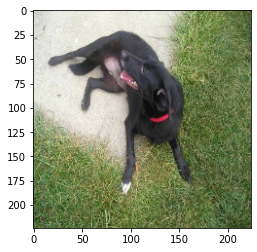

In [ ]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)

# 6. Define a model, loss funation, and optimizer

In [ ]:
def conv_layer(ni, no,kernal_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(ni,no, kernal_size, stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )

In [ ]:
def build_model():
  cnn_model = nn.Sequential(
      conv_layer(3,64,3),
      conv_layer(64,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      nn.Flatten(),
      nn.Linear(512,1),
      nn.Sigmoid(),
  ).to('cuda')

  loss_function= nn.BCELoss()
  optimizer = torch.optim.Adam(cnn_model.parameters(),lr =1e-3)

  return cnn_model, loss_function, optimizer

In [ ]:
cnn_model ,loss_function, optimizer = build_model()

In [ ]:
from torchsummary import summary

In [ ]:
summary(cnn_model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

# 7. Building a function to fetch the data for the training and validation folders

In [ ]:
def get_data():
  trainset = Cat_Dog(train_data)
  trainset_dl = DataLoader(trainset, batch_size = 32 , shuffle = True, 
                           drop_last = True)
  valset = Cat_Dog(test_data)
  valset_dl = DataLoader(valset, batch_size = 32,shuffle = True,
                         drop_last = True)
  
  return trainset_dl , valset_dl

# 8. Build a function to train the data

In [ ]:
def train_batch(x,y,model, loss_function,optimizer):
  model.train()
  prediction = model(x)
  batch_loss = loss_function(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  return batch_loss.item()



# 9. Build functions to calculate the accuracy and the validation loss



In [ ]:
@torch.no_grad()
def accuracy(x,y,model):
  model.eval()
  prediction = model(x)
  is_correct = (prediction>0.5) == y

  return is_correct.cpu().numpy().tolist()

In [ ]:
@torch.no_grad()
def valid_loss(x,y,model):
  model.eval()
  prediction = model(x)
  val_loss = loss_function(prediction,y)

  return val_loss.item()


# 10. Train the model

In [ ]:
trainset_dl , valset_dl = get_data()
cnn_model, loss_fn, optimizer = build_model()

In [ ]:
train_losses, train_accurcies = [],[]
val_losses , val_accuracies = [], []

In [ ]:
for epoch in range(10):
  print(f'Epoch {epoch+1}:')

  epoch_train_losses, epoch_train_accuracies, val_epoch_accuracies = [],[],[]

  for _,batch in enumerate(iter(trainset_dl)):
    x,y = batch
    batch_loss = train_batch(x,y,cnn_model,loss_fn, optimizer)
    epoch_train_losses.append(batch_loss)

  epoch_train_loss = np.array(epoch_train_losses).mean()
  print(f'Train Loss: {epoch_train_loss:0.3f}')
  train_losses.append(epoch_train_loss)

  for _,batch in enumerate(iter(trainset_dl)):
    x,y = batch
    is_correct = accuracy(x,y,cnn_model)
    epoch_train_accuracies.extend(is_correct)
  
  epoch_train_accuracy = np.mean(epoch_train_accuracies)
  print(f'Train Accuracy: {epoch_train_accuracy*100:0.0f}%')
  train_accurcies.append(epoch_train_accuracy)

  for _,batch in enumerate(iter(valset_dl)):
    x,y = batch
    #val_loss = valid_loss(x,y,cnn_model)
    val_acc = accuracy(x,y,cnn_model)
    val_epoch_accuracies.extend(val_acc)
  
  #print(f'Validation Loss: {val_loss:0.3f}')
  #val_losses.append(val_loss)

  val_epoch_accuracy = np.mean(val_epoch_accuracies)
  print(f'Validation Accuracy: {val_epoch_accuracy*100:0.0f}%')
  val_accuracies.append(val_epoch_accuracy)
  
  print('<--------------------------------------------------------->')



Epoch 1:
Train Loss: 0.601
Train Accuracy: 74%
Validation Accuracy: 72%
<--------------------------------------------------------->
Epoch 2:
Train Loss: 0.511
Train Accuracy: 77%
Validation Accuracy: 76%
<--------------------------------------------------------->
Epoch 3:
Train Loss: 0.410
Train Accuracy: 83%
Validation Accuracy: 82%
<--------------------------------------------------------->
Epoch 4:
Train Loss: 0.310
Train Accuracy: 88%
Validation Accuracy: 84%
<--------------------------------------------------------->
Epoch 5:
Train Loss: 0.242
Train Accuracy: 94%
Validation Accuracy: 89%
<--------------------------------------------------------->
Epoch 6:
Train Loss: 0.185
Train Accuracy: 96%
Validation Accuracy: 90%
<--------------------------------------------------------->
Epoch 7:
Train Loss: 0.142
Train Accuracy: 97%
Validation Accuracy: 90%
<--------------------------------------------------------->
Epoch 8:
Train Loss: 0.098
Train Accuracy: 90%
Validation Accuracy: 84%
<---